Check whether glob list is the same for `src/pCl.py` and `notebooks/Generate_pcl_th.ipynb`

In [6]:
import numpy as np

In [2]:
th_list = np.load("../dat/window_list_ordered.npy")
pcl_list = np.load("../dat/flist_pClpy.npy")

In [7]:
[int(i) for i in th_list[0].split() if i.isdigit()]

[]

In [19]:
res_th = []
for i in range(len(th_list)):
    res_th.append(int(th_list[i].split("/")[-1].split("_")[-1].split(".")[0]))

In [21]:
res_obs = []
for i in range(len(pcl_list)):
    res_obs.append(int(pcl_list[i].split("/")[-1].split("_")[-1].split(".")[0]))
    
res_obs

[1649,
 1499,
 1649,
 299,
 979,
 899,
 389,
 259,
 1979,
 879,
 1359,
 859,
 1699,
 829,
 179,
 1669,
 1259,
 1649,
 1439,
 719,
 289,
 1779,
 1929,
 1079,
 519,
 309,
 1019,
 409,
 809,
 369,
 1059,
 969,
 269,
 1739,
 269,
 1799,
 9,
 589,
 1609,
 549,
 1219,
 739,
 1559,
 1899,
 699,
 1429,
 339,
 1499,
 619,
 1109,
 1559,
 149,
 1809,
 189,
 1669,
 1259,
 1999,
 1249,
 1269,
 9,
 869,
 1159,
 1749,
 909,
 539,
 1189,
 349,
 259,
 1759,
 29,
 1329,
 1829,
 1389,
 349,
 1039,
 1919,
 1069,
 689,
 1359,
 469,
 869,
 1659,
 1839,
 509,
 669,
 1779,
 119,
 219,
 969,
 1529,
 519,
 1789,
 1169,
 599,
 389,
 879,
 949,
 1799,
 289,
 239,
 1139,
 1059,
 1929,
 609,
 1919,
 1849,
 1789,
 999,
 1479,
 319,
 159,
 1759,
 1299,
 659,
 649,
 1699,
 1129,
 749,
 609,
 869,
 69,
 289,
 1889,
 1039,
 1909,
 1619,
 1369,
 1089,
 1499,
 1329,
 759,
 469,
 1029,
 129,
 39,
 309,
 1189,
 669,
 229,
 1919,
 1739,
 919,
 1359,
 1289,
 1229,
 899,
 579,
 1569,
 339,
 709,
 1039,
 729,
 569,
 1709,
 1749

In [22]:
for i in range(len(res_th)):
    if(res_th[i] != res_obs[i]):
        print(i)

Test updated `src/pCl.py`

In [1]:
"""Calculate pCls based on mocks"""

#import numpy as np
import pandas as pd
#import healpy as hp
from astropy.io import fits

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

import sys
sys.path.insert(1, '/home/tkarim/imaging-sys-covariance/src/')
import params as pm
from lib import *

In [2]:
#list of all selection function fits files
#import glob
flist = np.load("../dat/window_list_ordered.npy")

#noise parameters
nbar_sr = (np.pi/180)**(-2) * pm.nbar_sqdeg #conversion factor from sq deg to sr
cls_shot_noise = 1/nbar_sr * np.ones_like(pm.ell)

#read in random to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
mask = np.copy(dr_elg_ran)
mask[dr_elg_ran != 0] = 1 #good pixels are 1
mask = mask.astype("bool")

#import avg map
Favg_map = np.load("../dat/windows/Favg/Favg_map_unpickled.npy")
#print(np.mean(Favg_map))

#import theory Cls generated from CLASS
cls_elg_th = np.load("/home/tkarim/imaging-sys-covariance/dat/cosmology_ini/gaussian_mocks/cl_th.npy")

##MAIN PART OF THE CODE##

print("Which model do you want to calculate?")
expname = 'F' #Look at notebook for definitions
#expname = sys.argv[1]
print("Running Model " + expname)

cls_obs = np.zeros((pm.NMOCKS, pm.LMAX)) #pCl values
nl = np.zeros(pm.NMOCKS) #selection function noise
fsky = np.zeros(pm.NMOCKS)

#set const. fsky and nl; fsky same in the first three models
if((expname == 'A')):
    fsky = np.sum(mask)/mask.shape[0] * np.ones(pm.NMOCKS)
    nl = np.mean(Favg_map)*1/nbar_sr*np.ones(pm.NMOCKS)
    tmpF = Favg_map #since fixed window set outside loop
elif((expname == 'B') | (expname == 'C')):
    fsky = np.sum(mask)/mask.shape[0] * np.ones(pm.NMOCKS)
elif(expname == 'D'):
    mask = mask & (Favg_map > pm.tol)
    fsky = np.sum(mask)/mask.shape[0] * np.ones(pm.NMOCKS)
    nl = np.mean(1/Favg_map[mask]) * 1/nbar_sr * np.ones(pm.NMOCKS)
    tmpF = Favg_map #since fixed window set outside loop

#model conditions; window applied to data vs random
#if((expname == 'A') | (expname == 'B') | (expname == 'C')):
#    divide_window = False
#else:
#    divide_window = True

#model conditions; additive component
if((expname == 'C') | (expname == 'E') | (expname == 'F')):
    additive = Favg_map
else:
    additive = None

#loop over mocks to calculate pCl
for i in range(pm.NMOCKS):

    #read in sel. function
    if((expname != 'A') & (expname != 'D')):
        #print("ok")
        tmpF = read_img_map(flist[i])
        
    #print(np.mean(tmpF[mask]))
        
    #set mask for E and F
    if((expname == 'E') | (expname == 'F')):
        mask = mask & (tmpF > pm.tol)
        fsky[i] = np.sum(mask)/mask.shape[0]
        nl[i] = np.mean(1/tmpF[mask]) * 1/nbar_sr
    elif((expname == 'B') | (expname == 'C')):
        nl[i] = np.mean(tmpF)*1/nbar_sr

    #renormalize selection function such that <F> = 1.
    masked_tmpF_mean = np.mean(tmpF[mask > 0])
    tmpF = tmpF/masked_tmpF_mean
    #print(np.mean(tmpF[mask]))    
    
    #calculate pCl
    seed = i+1
    #seed = 67
    #print(f'seed: {seed}')
    cls_obs[i] = cls_from_mock(expname= expname,
                cls_th = cls_elg_th,
                cls_shot_noise=cls_shot_noise, F = tmpF,
                mask = mask, seed = seed, LMAX_OUT = pm.LMAX,
                NSIDE = pm.NSIDE, additive = additive)
    #print(i)
    #print(cls_obs[i][:10])
    if((i % (100)) == 0):
        print(i)

#first order correction to pCls; fsky and nl
if((expname == 'A') | (expname == 'B') | (expname == 'C')):
    cls_obs = (cls_obs - nl[:,np.newaxis])/fsky[:,np.newaxis]
    #cls_obs = (cls_obs) - nl[:,np.newaxis]/fsky[:,np.newaxis] #only pcls
    #cls_obs = (cls_obs) - nl[:,np.newaxis]/fsky[:,np.newaxis] #only pcls
else:
    cls_obs = cls_obs/fsky[:,np.newaxis] - nl[:,np.newaxis]
    #cls_obs = cls_obs - nl[:,np.newaxis] #only pcls

#store values
np.save("../dat/pCls/1000mocks/pCls_" + expname + ".npy", cls_obs)
np.save("../dat/pCls/1000mocks/noise_window_" + expname + ".npy", nl)
np.save("../dat/pCls/1000mocks/fsky_" + expname + ".npy", fsky)

Which model do you want to calculate?
Running Model F
0
100
200
300
400
500
600
700
800
900


In [3]:
[9.68889278e-10 5.97702104e-07 1.26310869e-06 1.57831673e-06
 2.64003148e-07 1.16823348e-06 8.11139445e-07 1.66838530e-06
 1.27828758e-06 1.78105885e-06]

786432

In [16]:
[5.85160773e-08 1.64720127e-07 1.25690718e-07 2.03359107e-07
 2.72074597e-07 8.19101129e-07 7.34149609e-07 8.85132883e-07
 8.03842884e-07 4.35698345e-07]

4.5520785699999997e-07

In [3]:
pcl_A = np.load("../dat/pCls/th/pcl_th_Favg.npy")

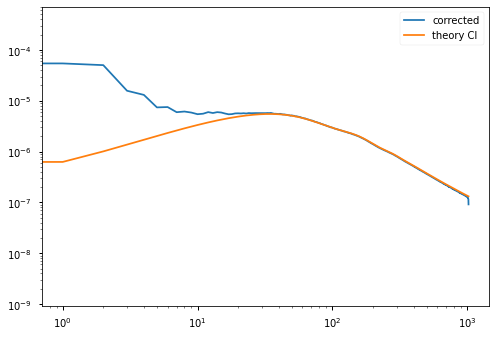

In [4]:
i = 0
lmx = pm.NSIDE
#plt.loglog((cls_obs[i]*fsky[i] + nl[i])[:1024], label = 'uncorrected with noise')
#plt.loglog((cls_obs[i]*fsky[i])[:1024] - nl[0]/fsky[0], label = 'uncorrected without noise')
plt.loglog(cls_obs.mean(axis = 0)[:lmx], label = 'corrected')
plt.loglog(cls_elg_th[:lmx], label = 'theory Cl')
#plt.loglog(pcl_A[:1024], label = 'theory pCl')
plt.legend(loc = 'best')

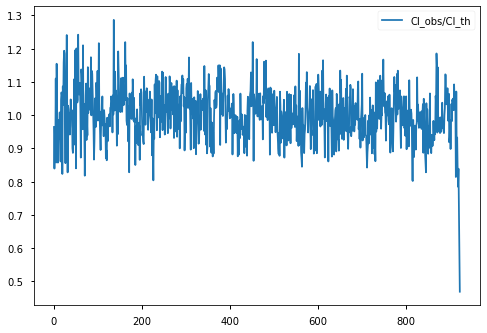

In [5]:
#plt.plot((cls_obs[0]*fsky[0])[100:1024]/pcl_A[100:1024], label = 'pCl_obs/pCl_th')
plt.plot((cls_obs[i])[100:lmx]/cls_elg_th[100:lmx], label = 'Cl_obs/Cl_th')
plt.legend(loc = 'best')

In [7]:
cls_obs.shape

(1000, 1024)

In [6]:
for i in range(1000):
    tmpmean = np.abs(1 - np.mean((cls_obs[i])[100:lmx]/cls_elg_th[100:lmx]))
    if(tmpmean > 0.03):
        print(i)
        print(tmpmean)

# Test Inference script

In [1]:
import emcee
import corner

In [13]:
def loglike(theta, data_binned, cov_binned):
    """
    Returns log likelihood 
    
    Arguments:
        theta (list) : list of parameters to be inferred; b1, Omega_c and A_s
        data_binned (array) : observed pCls binned
        cov_binned (matrix) : covariance matrix
    """
    
    theory = cgll(ell = pm.ell, bias = theta[0], Omega_c = theta[1], 
         Omega_b = 0.0486, h = 0.6774, sigma8 = 0.8, n_s = 0.965, transfer_function = 'eisenstein_hu')
    _, theory_binned = bin_mat(pm.ell, theory, pm.ELL)
    
    diff = theory_binned - data_binned
    
    invCov_binned = np.linalg.inv(cov_binned)
    
    return -0.5 * (diff).T @ invCov_binned @ diff

In [3]:
def mcmc(loglikelihood, data_binned, cov_binned, init_pos, nsamples, thread):
    """Returns emcee sampler based on log likelihood,
    initial position and number of walkers."""
    
    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    #initiate sampler and run
    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglikelihood, threads=thread,
                                   args = [data_binned, cov_binned])
    sampler.run_mcmc(p0, nsamples, progress=True);
    
    return sampler

def trace_autocorr(sampler, labels):
    """Returns traceplots and autocorrelation time
    of parameters based on emcee chain output.
    
    Parameters
    ----------
    samples : sampler.get_chain() output from emcee
    labels : names of parameters 
    """
    
    samples = sampler.get_chain()
    ndim = samples.shape[2]
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontsize = 15)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    #check auto-correlation time
    tau = sampler.get_autocorr_time()
    print(tau)
    
def burn_thin(sampler,  burn_in, thinning):
    """Returns flattened chains after burn-in and thinning."""
    
    flat_samples = sampler.get_chain(discard=burn_in, thin=thinning,
                    flat=True)
    return flat_samples

def cornerplot(flat_samples, **kwargs):
    figure = corner.corner(flat_samples, **kwargs)

In [4]:
b1 = 1.75
Omega_c = 0.2589
A_s = 2.2e-9

In [7]:
#setup walkers
nwalkers = 50; ndim = 2
#p0 = np.random.multivariate_normal(mean = np.array([b1, Omega_c, A_s]), 
#                                cov = np.array([[0.01, 0, 0], [0, 0.001, 0], [0, 0, 1e-10]]), 
#                              size = nwalkers)

p0 = np.hstack((np.random.normal(b1, .01, size = nwalkers), 
                np.random.normal(Omega_c, 0.001, size = nwalkers))).reshape(ndim, nwalkers).T

In [10]:
exp_names = np.array(['A'])
experiments = {}

#dict to store values
for name in exp_names:
    experiments[name] = {}

#load cls from memory

for key in experiments:
    experiments[key]['cls_obs'] = np.load("../dat/pCls/1000mocks/pCls_" + key + ".npy")
    experiments[key]['CLs_obs'] = np.zeros((pm.NMOCKS, pm.ELL.shape[0] - 1))
    experiments[key]['pCLs_obs'] = np.zeros((pm.NMOCKS, pm.ELL.shape[0] - 1))
    
   #read in fsky and nl
    experiments[key]['nl'] = np.load("../dat/pCls/1000mocks/noise_window_" +key +".npy")
    experiments[key]['fsky'] = np.load("../dat/pCls/1000mocks/fsky_" +key +".npy")
    
#calculate pCls
for key in ['A']:
    #experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] * experiments[key]['fsky'][:,np.newaxis]) + \
    #experiments[key]['nl'][:,np.newaxis]
    experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] * experiments[key]['fsky'][:,np.newaxis])

#bin power spectrum
for key in experiments:
    for i in range(pm.NMOCKS):
        ELL_mid, experiments[key]['CLs_obs'][i] = bin_mat(pm.ell[:pm.NSIDE], 
                                                           experiments[key]['cls_obs'][i][:pm.NSIDE],
                                                           pm.ELL) #Cls up to NSIDE is good 
        ELL_mid, experiments[key]['pCLs_obs'][i] = bin_mat(pm.ell[:pm.NSIDE], 
                                                           experiments[key]['pcls_obs'][i][:pm.NSIDE],
                                                           pm.ELL) #Cls up to NSIDE is good 

/home/tkarim/imaging-sys-covariance/src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [11]:
#calculate cov matrix and cumulative SN
for key in experiments: 
    experiments[key]['covmat'] = np.cov(experiments[key]['pCLs_obs'].T)
    experiments[key]['corrcoeff'] = np.corrcoef(experiments[key]['pCLs_obs'].T)
    experiments[key]['SN_cum'] = SN_cum(experiments[key]['covmat'], ELL_mid, 
                                       experiments[key]['pCLs_obs'].mean(axis = 0), lmax = pm.LMAX,
                                       use_hartlap=True, nsim = pm.NMOCKS)

In [14]:
data_binned = experiments['A']['CLs_obs'].mean(axis = 0)
cov_binned = experiments['A']['covmat']

#run sampler
%time sampler = mcmc(loglikelihood=loglike, \
                     data_binned = data_binned, cov_binned = cov_binned, \
                     init_pos=p0, nsamples=500, thread = 4)

100%|██████████| 500/500 [2:16:00<00:00, 16.32s/it]  

CPU times: user 1d 9h 52min 49s, sys: 52min 18s, total: 1d 10h 45min 8s
Wall time: 2h 16min 16s


In [15]:
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

Mean acceptance fraction: 0.6777600000000001


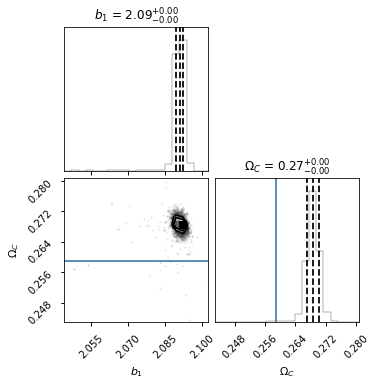

In [16]:
#burn-in and thinning
flat_samples = burn_thin(sampler, 50, 5)

#cornerplot
cornerplot(flat_samples, labels = [r"$b_{1}$", r"$\Omega_C$"],
        quantiles=np.array([.16, .5, .84]), truths=np.array([b1, Omega_c]),
        show_titles=True, title_kwargs={"fontsize": 12})

In [6]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
favg = np.load("../dat/windows/Favg/Favg_map_unpickled.npy")

In [4]:
cls_favg = hp.anafast(favg, pol=False, lmax=1024)

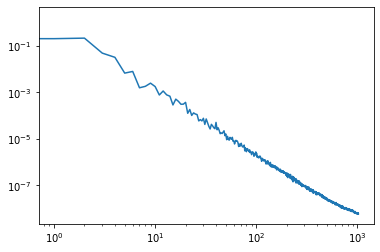

In [8]:
plt.loglog(cls_favg)

In [ ]:
#look at the feature importance weight as a function of scale to 
#understand which features are contributing to the window power
#spectrum. 

#look at the power spectra of the feature input maps 